In [1]:
import json
import os 
import re
import ast
import copy 
from datasets import load_dataset
import matplotlib.pyplot as plt 
import pandas as pd 

In [2]:
def convert_tools(input_string):
    # Split the input string into separate functions using the pattern
    pattern = r'(.*?):\s(.*?)\nParameters:\s(.*?)\nOutput:\s(.*?)\n\s-\sFormat:\s(.*?)\n\s-\sStructure:\s(.*?)\n'
    functions = re.findall(pattern, input_string, re.DOTALL)
    functions_list = []
    # Iterate over the functions and print them out
    for func in functions:
        tool = {}
        function_name, description, parameters, output, format_type, structure = func
        tool["name"] = function_name
        tool["description"] = description
        parameters_dict = json.loads(parameters)
        required_keys_list = []
        for key in parameters_dict.keys():
            value = parameters_dict[key]
            required_loc = value.find("Required.")
            if required_loc >= 0:
                required_keys_list.append(key)
                value = value[required_loc+9:].strip()
            key_type = value[:value.find('.')].strip()
            key_description = value[value.find('.')+1:].strip()
            new_value = {"type": key_type, "description": key_description}
            parameters_dict[key] = new_value
        tool["parameters"] = {"type": "object", "properties": parameters_dict, "required": required_keys_list}
        tool["output"] = output
        tool["format"] = format_type
        tool["structure"] = structure
        functions_list.append(tool)
    return json.dumps(functions_list)

In [3]:
def format_example(example, tools=None):
    new_example = {}
    if tools:
        new_example['tools'] = json.dumps(tools)
    else:
        new_example['tools'] = convert_tools(example['tools'][0])
    conversations = []
    if isinstance(example['conversations'], str):
        conversations_raw = json.loads(example['conversations'])
    else:
        conversations_raw = example['conversations']
    for item in conversations_raw:
        new_item = {}
        observation = None
        if item['role'] == 'user':
            new_item['from'] = 'human'
            new_item['value'] = item['content']
        elif item['role'] == 'assistant':
            new_item['from'] = 'gpt'
            new_item['value'] = item['content']
        elif item['role'] == 'tool':
            if conversations[-1]['from'] == 'gpt':
                conversations.pop()
            new_item['from'] = 'function_call'
            new_item['value'] = json.dumps({'name': item['name'], 'arguments': item['parameters']})
            if 'observation' in item:
                observation = {'from': 'observation', 'value': item['observation']}
        conversations.append(new_item)
        if observation is not None:
            conversations.append(observation)
    new_example['conversations'] = conversations
    return new_example

In [4]:
def format_example_dev(example, tools=None):
    new_example = {}
    if tools:
        new_example['tools'] = json.dumps(tools)
    else:
        new_example['tools'] = convert_tools(example['tools'][0])
    conversations = []
    if isinstance(example['conversations'], str):
        conversations_raw = json.loads(example['conversations'])
    else:
        conversations_raw = example['conversations']
    for item in conversations_raw:
        new_item = {}
        observation = None
        if item['role'] == 'user':
            new_item['from'] = 'human'
            new_item['value'] = item['content']
        elif item['role'] == 'assistant':
            new_item['from'] = 'gpt'
            new_item['value'] = item['content']
        elif item['role'] == 'tool':
            if conversations[-1]['from'] == 'gpt':
                conversations.pop()
            new_item['from'] = 'function_call'
            new_item['value'] = json.dumps({'name': item['name'], 'arguments': item['parameters']})
            if 'observation' in item:
                observation = {'from': 'observation', 'value': item['observation']}
        conversations.append(new_item)
        if observation is not None:
            conversations.append(observation)
    new_example['conversations'] = conversations[:2]
    return new_example

In [5]:
# roborock 数据集

In [6]:
with open('ToolAlpaca/data/formatted_data/robocontrol_dataset.jsonl', "r", encoding="utf-8") as f:
    if 'robocontrol_dataset.jsonl'.endswith(".json"):
        train_data = json.load(f)
    elif 'robocontrol_dataset.jsonl'.endswith(".jsonl"):
        train_data = [json.loads(line) for line in f]

In [7]:
with open('ToolAlpaca/data/formatted_data/robocontrol_dataset_testset.jsonl', "r", encoding="utf-8") as f:
    if 'robocontrol_dataset_testset.jsonl'.endswith(".json"):
        dev_data = json.load(f)
    elif 'robocontrol_dataset_testset.jsonl'.endswith(".jsonl"):
        dev_data = [json.loads(line) for line in f]

In [8]:
tools = json.loads(train_data[0]['tools'])

In [9]:
for i in range(len(tools)):
    tool = tools[i]
    
    if (tool['parameters'] is None):
        tool['parameters'] = {'type': 'object', 'properties': {}}
    elif tool['parameters'].get('properties', None) is None:
        tool['parameters']['properties'] = {}
    parameters = list(tool['parameters']['properties'].keys())
    
    required = tool['parameters'].get('required', None)
    if required is None:
        required = tool.get('required', None)
        if required is None:
            tool['parameters']['required'] = []
        else:
            tool['parameters']['required'] = required
            
    for name in tool['parameters']['required']:
        if name not in parameters:
            print(i, tool)
            break

0 {'name': 'general_control', 'description': 'This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task', 'parameters': {'type': 'object', 'properties': {'action': {'type': 'string', 'enum': ['start', 'stop', 'pause', 'resume']}, 'user_defined_task': {'type': 'string', 'description': 'user-defined task described in user request'}}, 'required': ['operation_type']}}
11 {'name': 'mapping', 'description': 'api for building map', 'parameters': {'type': 'object', 'properties': {'action': {'type': 'string', 'enum': ['start', 'stop', 'pause', 'resume']}}, 'required': ['operation_type']}}


In [10]:
tool_name = "mapping"

In [11]:
keys_list = []
records = []
len_records = []
for i in range(len(train_data)):
    if json.loads(train_data[i]['conversations'])[1]["role"] == "tool":
        if json.loads(train_data[i]['conversations'])[1]['name'] == tool_name:
            parameters = json.loads(train_data[i]['conversations'])[1]['parameters']
            if parameters is None:
                keys = []
                keys_list += keys
            else:
                keys = list(parameters.keys())
                keys_list += keys
            records.append((i, len(keys)))
            len_records.append(len(keys))
    else:
        assert json.loads(train_data[i]['conversations'])[1]["role"] == "assistant"
print(set(keys_list))
print(set(len_records))

{'action'}
{1}


In [12]:
tool_name = "general_control"

In [13]:
keys_list = []
records = []
len_records = []
for i in range(len(train_data)):
    if json.loads(train_data[i]['conversations'])[1]["role"] == "tool":
        if json.loads(train_data[i]['conversations'])[1]['name'] == tool_name:
            parameters = json.loads(train_data[i]['conversations'])[1]['parameters']
            if parameters is None:
                keys = []
                keys_list += keys
            else:
                keys = list(parameters.keys())
                keys_list += keys
            records.append((i, len(keys)))
            len_records.append(len(keys))
    else:
        assert json.loads(train_data[i]['conversations'])[1]["role"] == "assistant"
print(set(keys_list))
print(set(len_records))

{'action', 'user_defined_task'}
{1, 2}


In [14]:
for i in records:
    if i[1] == 1:
        print(train_data[i[0]]['conversations'])

[{"role": "user", "content": "Timeout"}, {"role": "tool", "name": "general_control", "parameters": {"action": "pause"}}]
[{"role": "user", "content": "立即停止"}, {"role": "tool", "name": "general_control", "parameters": {"action": "stop"}}]
[{"role": "user", "content": "稍等"}, {"role": "tool", "name": "general_control", "parameters": {"action": "pause"}}]
[{"role": "user", "content": "给我开始"}, {"role": "tool", "name": "general_control", "parameters": {"action": "start"}}]
[{"role": "user", "content": "恢复动作"}, {"role": "tool", "name": "general_control", "parameters": {"action": "resume"}}]
[{"role": "user", "content": "启动任务"}, {"role": "tool", "name": "general_control", "parameters": {"action": "start"}}]
[{"role": "user", "content": "Freeze"}, {"role": "tool", "name": "general_control", "parameters": {"action": "pause"}}]
[{"role": "user", "content": "中断任务"}, {"role": "tool", "name": "general_control", "parameters": {"action": "pause"}}]
[{"role": "user", "content": "继续前进"}, {"role": "tool"

In [15]:
tools[0]['parameters']['required'] = ['action']
tools[11]['parameters']['required'] = ['action']

In [16]:
for i in range(len(tools)):
    tool = tools[i]
    assert 'properties' in tool['parameters']
    assert isinstance(tool['parameters']['properties'], dict)
    assert 'required' in tool['parameters']
    assert isinstance(tool['parameters']['required'], list)

In [17]:
train_data_new = []
for i in range(len(train_data)):
    try:
        train_data_new.append(format_example(train_data[i], tools))
    except:
        # print(i)
        pass

In [18]:
len(train_data_new)

3232

In [19]:
dev_data_new = []
for i in range(len(dev_data)):
    try:
        dev_data_new.append(format_example_dev(dev_data[i], tools))
    except:
        # print(i)
        pass

In [20]:
len(dev_data_new)

1078

In [22]:
dev_data_new[0]

{'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["action"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "location": {"type": "string", "description": "Fill in the description of the location from the user request word for word, using the same language as in the user\'s description of the location."}, "tool": {"type": "

In [24]:
for i in range(len(train_data)):
    if train_data[i]['num_decomposition'] > 1:
        print(i)

299
376


In [33]:
train_data_new[299]

{'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["action"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "location": {"type": "string", "description": "Fill in the description of the location from the user request word for word, using the same language as in the user\'s description of the location."}, "tool": {"type": "

In [34]:
train_data[299]

{'user_request': '查看前五条和后五条预约任务',
 'task_decomposition': '[{"name": "schedule_operation", "parameters": {"operation_type": "query", "index_from": 1, "index_to": 5}}, {"name": "schedule_operation", "parameters": {"operation_type": "query", "index_from": -5, "index_to": -1}}]',
 'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["operation_type"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action

In [386]:
for i in range(len(train_data)):
    if train_data[i]['hit'] == False:
        print(i)

71
110
229
266
308
331
351
412
433
446
670
700
871
990
997
1006
1094
1100
1103
1179
1243
1452
1456
1527
1540
1592
1593
1799
1883
1895
1947
2024
2225
2257
2306
2475
2537
2657
2698
2715
2721
2779
2853
2955
3080
3163
3201


In [389]:
train_data[3201]

{'user_request': 'user_defined_task:[Open Area Polish|Basement De-clutter]$$Switch on Attic Arrangement',
 'task_decomposition': '"<null>"',
 'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["operation_type"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "location": {"type": "string", "description": "Fill in the descript

In [388]:
train_data_new[3201]

{'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["action"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "location": {"type": "string", "description": "Fill in the description of the location from the user request word for word, using the same language as in the user\'s description of the location."}, "tool": {"type": "

In [384]:
train_data_new[0]

{'tools': '[{"name": "general_control", "description": "This API is used for controlling general tasks, typically providing control for listed user-defined tasks, or that is not directly tied to specific task types, or non-clean task", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "user_defined_task": {"type": "string", "description": "user-defined task described in user request"}}, "required": ["action"]}}, {"name": "clean", "description": "Initiate a task of an immediate or unscheduled cleaning or partial clean, i.e., cleaning a part while leaving another part untouched.", "parameters": {"type": "object", "properties": {"action": {"type": "string", "enum": ["start", "stop", "pause", "resume"]}, "location": {"type": "string", "description": "Fill in the description of the location from the user request word for word, using the same language as in the user\'s description of the location."}, "tool": {"type": "

In [25]:
with open('ToolAlpaca/data/formatted_data/robocontrol_dataset_sharegpt.json', 'w') as file:
    data = json.dump(train_data_new, file)
with open('ToolAlpaca/data/formatted_data/robocontrol_dataset_sharegpt.json', 'r') as f:
    data = json.load(f)
for i in range(len(data)):
    assert data[i] == train_data_new[i]

In [26]:
with open('ToolAlpaca/data/formatted_data/robocontrol_dataset_testset_sharegpt.json', 'w') as file:
    data = json.dump(dev_data_new, file)
with open('ToolAlpaca/data/formatted_data/robocontrol_dataset_testset_sharegpt.json', 'r') as f:
    data = json.load(f)
for i in range(len(data)):
    assert data[i] == dev_data_new[i]

In [27]:
# result analysis 

In [123]:
# sft 

In [23]:
with open('../models/roborock_control_lora_Yi_high_ppl/checkpoint-50/trainer_state.json', 'r') as f:
    train_state = json.load(f)

In [24]:
log_history = train_state['log_history']
steps = [i['step'] for i in log_history]
learning_rate = [i['learning_rate'] for i in log_history]
loss = [i['loss'] for i in log_history]

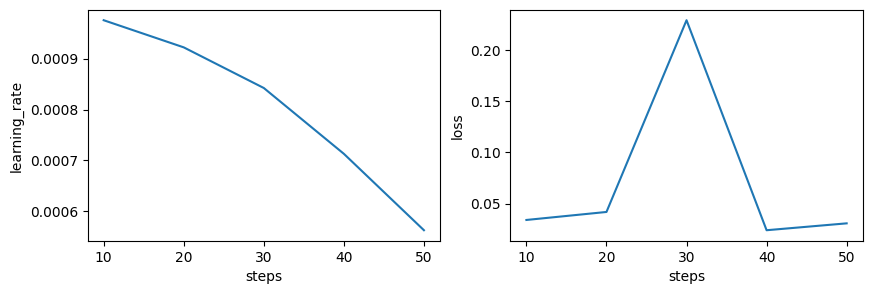

In [25]:
# Create a figure and two subplots, sharing the same y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot data on each axis
ax1.plot(steps, learning_rate)
ax2.plot(steps, loss)

# Optionally, set titles for each subplot
ax1.set_xlabel('steps')
ax1.set_ylabel('learning_rate')
ax2.set_xlabel('steps')
ax2.set_ylabel('loss')

# Show the figure
plt.show()

In [26]:
def parse_tool_call(input_string):
    # 正则表达式匹配括号内的内容
    args_match = re.search(r".*tool_call\((.*)\).*", input_string)
    if not args_match:
        return "No arguments found."

    # 获取括号内的所有参数字符串
    args_string = args_match.group(1)

    # 使用堆栈来处理嵌套结构
    args_list = []
    stack = []
    last_index = 0
    for i, char in enumerate(args_string):
        if char == '{':
            stack.append(char)
        elif char == '}':
            stack.pop()
        elif char == ',' and not stack:
            # 当遇到逗号且堆栈为空时，表示这是一个顶级参数的分隔符
            args_list.append(args_string[last_index:i])
            last_index = i + 2  # 跳过逗号和空格

    # 添加最后一个参数到列表中
    args_list.append(args_string[last_index:])

    # 解析每个参数为键值对，并存储在字典中
    args_dict = {}
    try:
        for arg in args_list:
            key, value = arg.split('=', 1)
            args_dict[key.strip()] = ast.literal_eval(value.strip())
    except:
        pass

    return args_dict


def parse_action_input(input_string):
    # 使用正则表达式提取 Action 和 Action Input
    action_match = re.search(r'Action: (\w+)', input_string)
    action_input_match = re.search(r'Action Input:.*(\{.*\})', input_string)

    # 检查是否找到匹配项并提取
    action = action_match.group(1) if action_match else None
    action_input = json.loads(action_input_match.group(1)) if action_input_match else None
    return action, action_input


def format_prediction(input_string):
    input_string = input_string.strip()
    if (input_string.find('Action') >= 0) or (input_string.find('Action Input') >= 0):
        intent, slot = parse_action_input(input_string)
    else:
        intent = ''
        slot = {}
    return intent, slot


def cal_metric(label, prediction):
    target_intent, target_method = format_prediction(label)
    prediction_intent, prediction_method = format_prediction(prediction)
    if prediction_intent == target_intent:
        if prediction_method == target_method:
            result = [1, 1]
        else:
            result = [1, 0]
    else:
        result = [0, 0]
    return result


def cal_lora(generated_results, model_name, set_name):
    print(model_name, set_name)
    results = []
    for i in range(len(generated_results)):
        label = generated_results[i]['label']
        prediction = generated_results[i]['predict']
        try:
            result = cal_metric(label, prediction)
        except:
            print('oops', i)
        result += [dev_data_new[i]['conversations'][0]['value'], label, prediction]
        results.append(result)
    results = pd.DataFrame(results)
    results.columns = ['intent', 'slot', 'query', 'target', 'prediction']
    results['model_name'] = model_name
    results['set_name'] = set_name
    results = results.reset_index()
    return results


def cal_accuracy(results):
    num = results.shape[0]
    intent = results['intent']
    zero_error_count = intent.shape[0]
    zero_error_rate = 1
    intent_sum, intent_mean = intent.sum(), intent.mean()
    slot = results[(results['intent'] == 1)]['slot']
    slot_sum, slot_mean = slot.sum(), slot.mean()
    both_mean = slot_sum / zero_error_count
    return pd.Series([num, zero_error_count, zero_error_rate, intent_sum, intent_mean, slot_sum, slot_mean, both_mean],
                     index=['num', 'zero_error_count', 'zero_error_rate', 'intent_sum', 'intent_mean', 'slot_sum',
                            'slot_mean', 'both_mean'])

In [27]:
with open('../outputs/roborock_control_lora_Yi_high_ppl_test_100/generated_predictions.jsonl', 'r') as f:
    generated_results = [json.loads(line) for line in f]

In [28]:
results = []
results.append(cal_lora(generated_results, '1finetune', '2test'))
# results.append(cal_lora(train_generated_results, '1finetue', '1train'))
results = pd.concat(results, axis=0)
results = results.reset_index(drop=True)

1finetune 2test


In [29]:
results.groupby(['model_name', 'set_name']).apply(cal_accuracy)

/tmp/ipykernel_407604/878948027.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results.groupby(['model_name', 'set_name']).apply(cal_accuracy)


,,num,zero_error_count,zero_error_rate,intent_sum,intent_mean,slot_sum,slot_mean,both_mean
model_name,set_name,,,,,,,,
1finetune,2test,100.0,100.0,1.0,96.0,0.96,80.0,0.833333,0.8


In [24]:
results.groupby(['model_name', 'set_name']).apply(cal_accuracy)

/tmp/ipykernel_390362/878948027.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results.groupby(['model_name', 'set_name']).apply(cal_accuracy)


,,num,zero_error_count,zero_error_rate,intent_sum,intent_mean,slot_sum,slot_mean,both_mean
model_name,set_name,,,,,,,,
1finetune,2test,100.0,100.0,1.0,96.0,0.96,86.0,0.895833,0.86
